## Load Data

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def load_searchtrans(path, sep=","):
    cols = [
        "wcai_market", "LODG_SRCH_REQST_KEY", "GUID", "SRCH_DATETM", "TUID", "TRVL_PRODUCT_ID", "PARTNR_ID", "SRCH_BEGIN_USE_DATE",
        "SRCH_END_USE_DATE", "SRCH_RM_CNT", "SRCH_ADULT_CNT", "SRCH_CHILD_CNT", "RESOLVED_DEST_REGN_ID", "SRCH_MIN_STAR_RTG", 
        "TOTL_RESULTS_CNT", "SRCH_DEST_TXT", "SRCH_LODG_PROPERTY_NAME", "SRT_TYP_ID", "LODG_RESP_PAGE_DESC", "TRL", "CLICK_THRU_DATETM", "CLICK_THRU_TYP_ID",
        "RESP_LODG_PROPERTY_ID", "RESP_PAGE_POSITION_VALUE", "RESP_BUSINESS_MODEL_ID", "LODG_PROPERTY_AVAIL_STATE_ID", "RESP_STAR_RTG_VALUE","TRVLR_REVIEW_AVG_RTG",
        "TRVLR_REVIEW_CNT", "LOWST_AVG_PRICE_AMT", "IS_PROMO_FLAG", "REGIONID", "REGIONSEMANTICDESC", "REGIONTYPEID", "MARKETID", "MARKETNAME","PSG_REGION",
        "PSG_SUPERREGION", "Hotel_Name", "Structure_Type_ID", "Room_Capacity", "Center_Latitude", "Center_Longitude", "Primary_Booking_Source", "Sub_Market_Name", "Brand_Name", 
        "Parent_Chain_Name", "City", "State", "Country", "ARI_Enabled_Bool", "Airport_Code", "Merchant_Bool"
    ]
    data = pd.read_csv(path, sep=sep, header=None,)
    data.columns = cols
    return data

def select_feat_st(st):
    ## initial selection
    data = st[["TUID", "Hotel_Name", "TRVL_PRODUCT_ID", "SRCH_RM_CNT", "SRCH_ADULT_CNT", "SRCH_MIN_STAR_RTG", "TOTL_RESULTS_CNT",
               "SRT_TYP_ID","RESP_PAGE_POSITION_VALUE", "LODG_RESP_PAGE_DESC", "REGIONTYPEID", "Room_Capacity", 
               "RESP_STAR_RTG_VALUE", "TRVLR_REVIEW_AVG_RTG", "TRVLR_REVIEW_CNT", 
            ]].copy()

    ## Preprocess
    ## is promoted
    data["IS_PROMO_FLAG"] = st["IS_PROMO_FLAG"].map({"Y":1, "N":0})

    ## available
    data["LODG_PROPERTY_AVAIL_STATE_ID"] = st["LODG_PROPERTY_AVAIL_STATE_ID"].apply(lambda x: int(x) if x in ("4","2","1") else x)

    ## price 
    data["LOWST_AVG_PRICE_AMT"] = st["LOWST_AVG_PRICE_AMT"]

    ## Purchase
    data["purchase"] = st["CLICK_THRU_TYP_ID"].apply(lambda x: 1 if x=="3406" or x==3406 else 0)

    ## Viewed detail
    data["viewed_detail"] = st["CLICK_THRU_TYP_ID"].apply(lambda x: 1 if x=="3402" or x==3402 else 0)

    ## Viewed price
    data["viewed_price"] = st["CLICK_THRU_TYP_ID"].apply(lambda x: 1 if x=="3404" or x==3404 else 0)
    
    ## drop if price is nan
    data.replace({r"\N": np.nan}, inplace=True)
    data.dropna(subset=["LOWST_AVG_PRICE_AMT"], inplace=True)
    
    ## drop duplicate IDs
    data.iloc[:,2:] = data.iloc[:,2:].astype(float)
    data = data.drop_duplicates(subset=["TUID", "Hotel_Name"])
    data.dropna(subset=["TUID", "Hotel_Name"], inplace=True)
    
    ## drop if rating is nan
    data.dropna(subset=["TRVLR_REVIEW_AVG_RTG"], inplace=True)

    return data

def encode_Ids(dt):

    data = dt.copy()
    data.loc[:, "TUID"] = data["TUID"].astype(int)
    data["TUID"] = LabelEncoder().fit_transform(data["TUID"])
    data["Hotel_Name"] = LabelEncoder().fit_transform(data["Hotel_Name"])
    return data
    

data = load_searchtrans("/user/hl3541/RL_Expedia/Expedia/Search_Trans/search_trans.csv")
data = select_feat_st(data)
data = encode_Ids(data)
rating = data[["TUID", "Hotel_Name", "TRVLR_REVIEW_AVG_RTG"]]
# rating.to_pickle("./rating.pkl")

/tmp/6955783.1.debian.q/ipykernel_8957/222781610.py:72: DtypeWarning: Columns (4,5,6,9,10,11,12,13,14,17,18,19,21,22,23,24,25,26,31,33,34,39,40,41,42,43,50,52) have mixed types.Specify dtype option on import or set low_memory=False.
  data = load_searchtrans("/user/hl3541/RL_Expedia/Expedia/Search_Trans/search_trans.csv")


In [40]:
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def list_to_mat(data, dims):
    m, n = dims
    n_obs = len(data[:, 0])
    out = np.zeros((m, n))

    for ind in range(n_obs):
        i, j = data[ind, :2]
        out[i, j] = data[ind, -1]

    return out

rating = pd.read_pickle("./rating.pkl").values
n_U, n_I = int(rating[:, 0].max() + 1), int(rating[:, 1].max() + 1)
rating = list_to_mat(rating, (n_U, n_I))
rating

array([[0. , 0. , 0. , ..., 0. , 3.9, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

## Variational Inference

In [20]:
from Hierarchical_Poisson_Factorization import *
set_seed()    

hpf = HPF(rating, K=10)
LJ, losses = hpf.variational_inference()

  5%|▌         | 1/20 [00:07<02:23,  7.56s/it]

Epoch0: log joint=-787807.62, loss=0.51


 10%|█         | 2/20 [00:15<02:17,  7.62s/it]

Epoch1: log joint=-776493.84, loss=0.51


 15%|█▌        | 3/20 [00:22<02:09,  7.60s/it]

Epoch2: log joint=-760084.91, loss=0.50


 20%|██        | 4/20 [00:30<02:01,  7.60s/it]

Epoch3: log joint=-721729.07, loss=0.47


 25%|██▌       | 5/20 [00:37<01:53,  7.57s/it]

Epoch4: log joint=-644115.19, loss=0.43


 30%|███       | 6/20 [00:45<01:46,  7.58s/it]

Epoch5: log joint=-539116.57, loss=0.36


 35%|███▌      | 7/20 [00:53<01:38,  7.58s/it]

Epoch6: log joint=-450450.07, loss=0.32


 40%|████      | 8/20 [01:00<01:31,  7.61s/it]

Epoch7: log joint=-386607.57, loss=0.29


 45%|████▌     | 9/20 [01:08<01:23,  7.61s/it]

Epoch8: log joint=-346317.00, loss=0.28


 50%|█████     | 10/20 [01:16<01:16,  7.62s/it]

Epoch9: log joint=-326178.83, loss=0.27


 55%|█████▌    | 11/20 [01:23<01:08,  7.59s/it]

Epoch10: log joint=-317182.88, loss=0.27


 60%|██████    | 12/20 [01:31<01:00,  7.60s/it]

Epoch11: log joint=-312882.26, loss=0.27


 65%|██████▌   | 13/20 [01:38<00:53,  7.58s/it]

Epoch12: log joint=-310102.66, loss=0.26


 70%|███████   | 14/20 [01:46<00:45,  7.56s/it]

Epoch13: log joint=-308043.66, loss=0.26


 75%|███████▌  | 15/20 [01:53<00:37,  7.56s/it]

Epoch14: log joint=-306468.45, loss=0.26


 80%|████████  | 16/20 [02:01<00:30,  7.55s/it]

Epoch15: log joint=-305254.24, loss=0.26


 85%|████████▌ | 17/20 [02:08<00:22,  7.53s/it]

Epoch16: log joint=-304329.02, loss=0.26


 90%|█████████ | 18/20 [02:16<00:15,  7.54s/it]

Epoch17: log joint=-303598.27, loss=0.26


 95%|█████████▌| 19/20 [02:23<00:07,  7.54s/it]

Epoch18: log joint=-303003.36, loss=0.26


100%|██████████| 20/20 [02:31<00:00,  7.58s/it]

Epoch19: log joint=-302513.82, loss=0.26


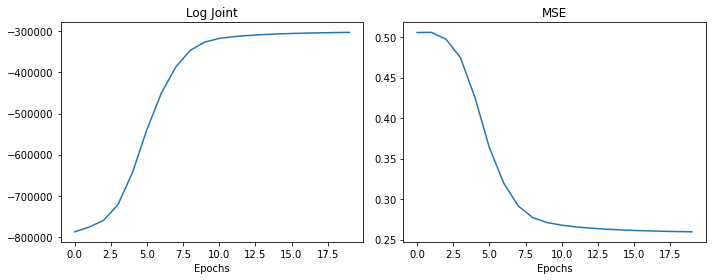

In [22]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

axes[0].plot(LJ)
axes[0].set_xlabel("Epochs")
axes[0].set_title("Log Joint")

axes[1].plot(losses, label="Training set Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_title("MSE")

plt.tight_layout()


In [75]:
pred = hpf.pred
top1, top5, top10 = accuracy(pred, rating, (1, 5, 10))
print(f"top1 accuracy: {top1:.4f}, top5 accuracy: {top5:.4f}, top10 accuracy: {top10:.4f}")

top1 accuracy: 0.0783, top5 accuracy: 0.6917, top10 accuracy: 0.9452


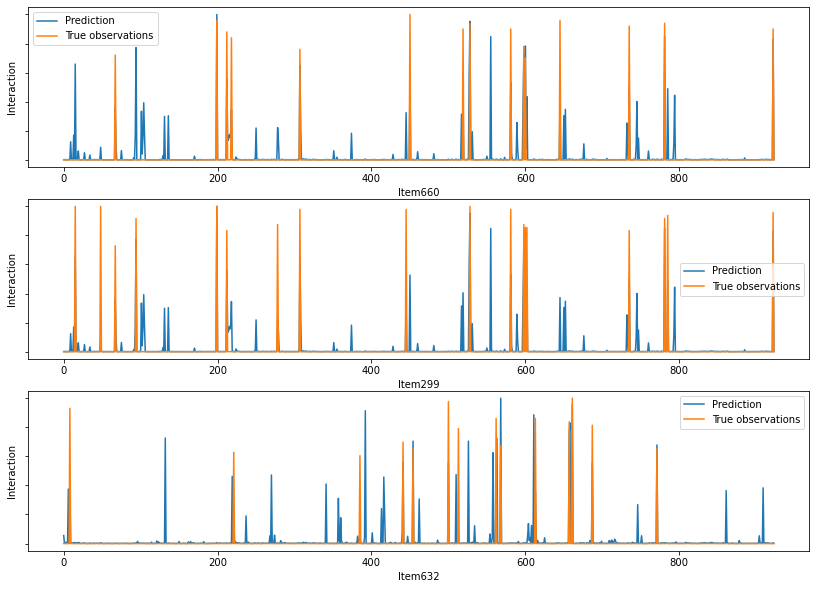

In [31]:
# pred = posterior["theta"] @ posterior["beta"].T

fig, ax = plt.subplots(figsize=(14, 10), nrows=3)

for u,i in enumerate(np.random.choice(hpf.n_I, 3)):
    ax[u].plot(pred[i]/pred[i].max(), label = "Prediction")
    ax[u].plot(rating[i]/rating[i].max(), label = "True observations")
    ax[u].set_xlabel(f"Item{i}")
    ax[u].set_ylabel("Interaction")
    ax[u].set_yticklabels([])
    ax[u].legend()

## On the latent dimension

100%|██████████| 20/20 [11:07<00:00, 33.38s/it]


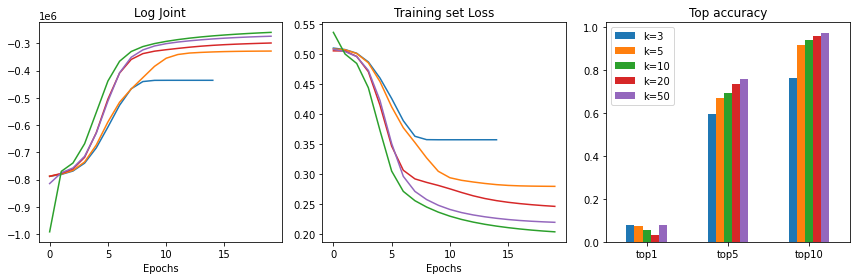

In [22]:
from Hierarchical_Poisson_Factorization import *
set_seed()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
res_acc = {}
for i, k in enumerate([3, 5, 10, 20, 50]):
    hpf = HPF(rating, K=k)
    LJ, losses = hpf.variational_inference(n_epochs=20, verbose=False)
    cmap = ["tab:blue", "tab:orange", "tab:red", "tab:purple", "tab:green"]
    
    axes[0].plot(LJ, color=cmap[i])
    axes[0].set_xlabel("Epochs")
    axes[0].set_title("Log Joint")

    axes[1].plot(losses, color=cmap[i])
    axes[1].set_xlabel("Epochs")
    axes[1].set_title("Training set Loss")

    pred = hpf.pred
    acc = accuracy(pred, rating, (1, 5, 10))
    res_acc.update({f"k={k}":acc})

res_acc = pd.DataFrame(res_acc, index=["top1", "top5", "top10"])
res_acc.plot.bar(rot=0, ax=axes[2])
axes[2].set_title("Top accuracy")
plt.tight_layout()
    

In [28]:
res_acc

,k=3,k=5,k=10,k=20,k=50
top1,0.076389,0.075231,0.057099,0.033565,0.077932
top5,0.594522,0.670910,0.691744,0.734568,0.756173
top10,0.761188,0.916667,0.937500,0.957176,0.972222
